# Random Forest Modeling

The purpose of this notebook is to build some preliminary modeling with random forest/tree-based approaches.  KNN and Logistic Regression Models were originally explored in initial_model_eda.ipynb and improved upon in second_model.ipynb, using a dataset with additional features.  That same dataset (training_horses_2.pkl) will be utilized here.

Package imports:

In [94]:
import pandas as pd
from importlib import reload
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

import matplotlib.cm as cm
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

Reading in Pickled Data:

In [95]:
training_horses_2 = pd.read_pickle('./Data/training_horses_2_cleaned.pkl')

In [96]:
training_horses_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59605 entries, 1 to 79203
Data columns (total 39 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   race_id                                       59605 non-null  int64  
 1   horse_id                                      59605 non-null  int64  
 2   result                                        59605 non-null  int64  
 3   lengths_behind                                59605 non-null  float64
 4   horse_age                                     59605 non-null  int64  
 5   horse_type                                    59605 non-null  object 
 6   horse_country                                 59605 non-null  object 
 7   horse_rating                                  59605 non-null  int64  
 8   horse_gear                                    59605 non-null  object 
 9   declared_weight                               59605 non-null 

In [97]:
training_horses_2_copy = training_horses_2.copy()

## Feature Selection

Adding career show rate:

In [98]:
training_horses_2_copy['career_show_rate'] = training_horses_2_copy['career_shows'] / training_horses_2_copy['career_races']

In [99]:
training_horses_2_copy.sample(10)

,race_id,horse_id,result,lengths_behind,horse_age,horse_type,horse_country,horse_rating,horse_gear,declared_weight,...,avg_field_dec_wgts,diff_from_field_declared_wgt_avg,field_dec_wgt_rank,avg_field_actual_wgt,diff_from_field_handicap_wgt_avg,field_handicap_wgt_rank,career_races,career_shows,shows_in_last_5_races,career_show_rate
52311,2171,1270,7,2.50,3,Gelding,AUS,60,--,1108.0,...,1084.416667,23.583333,3,123.416667,-3.416667,9,3,0.0,0.0,0.000000
75193,338,583,2,0.20,3,Gelding,AUS,60,--,1026.0,...,1076.500000,-50.500000,8,124.500000,7.500000,2,6,0.0,0.0,0.000000
27721,4131,3592,3,3.25,3,Gelding,IRE,60,--,977.0,...,1094.571429,-117.571429,14,122.071429,-9.071429,14,49,8.0,2.0,0.163265
6014,5866,2292,5,1.75,2,Gelding,NZ,78,--,1062.0,...,1119.666667,-57.666667,10,123.083333,9.916667,1,4,0.0,0.0,0.000000
71773,617,1079,12,6.00,3,Gelding,NZ,60,--,1064.0,...,1069.846154,-5.846154,7,120.923077,7.076923,3,7,3.0,3.0,0.428571
28458,4073,3892,12,7.75,3,Gelding,AUS,60,--,1127.0,...,1101.769231,25.230769,4,125.076923,-17.076923,13,18,1.0,0.0,0.055556
2589,6141,607,11,9.25,5,Gelding,AUS,53,P/XB,1009.0,...,1095.454545,-86.454545,11,123.909091,-0.909091,8,24,9.0,1.0,0.375000
16376,5041,2756,4,2.00,5,Gelding,AUS,35,TT,1168.0,...,1090.428571,77.571429,2,125.000000,1.000000,4,35,9.0,1.0,0.257143
64694,1174,1069,3,2.00,3,Gelding,IRE,60,--,1124.0,...,1081.000000,43.000000,1,125.090909,0.909091,4,14,3.0,1.0,0.214286
9797,5565,1588,1,0.00,3,Gelding,AUS,103,TT,1129.0,...,1115.785714,13.214286,5,124.285714,-0.285714,8,4,4.0,4.0,1.000000


Will use similar features as in my previous models, but will not be OHE'ing the horse_type variable with the Tree-based models.

In [100]:
columns_1 = ['horse_age', 'declared_weight', 'actual_weight', 'horse_rating', 'draw', 'three_race_rolling_avg_finish', 'three_race_rolling_average_lengths', 'three_race_rolling_average_time', 'three_race_rolling_average_distance_per_time', 'field_rating_rank', 'diff_from_field_rating_avg', 'field_age_rank', 'diff_from_field_age_avg', 'diff_from_field_declared_wgt_avg', 'field_dec_wgt_rank', 'diff_from_field_handicap_wgt_avg', 'field_handicap_wgt_rank', 'career_races', 'career_shows', 'shows_in_last_5_races', 'career_show_rate']

In [101]:
for i, feature in enumerate(columns_1, 1):
    print("Feature {}: {}".format(i, feature))

Feature 1: horse_age
Feature 2: declared_weight
Feature 3: actual_weight
Feature 4: horse_rating
Feature 5: draw
Feature 6: three_race_rolling_avg_finish
Feature 7: three_race_rolling_average_lengths
Feature 8: three_race_rolling_average_time
Feature 9: three_race_rolling_average_distance_per_time
Feature 10: field_rating_rank
Feature 11: diff_from_field_rating_avg
Feature 12: field_age_rank
Feature 13: diff_from_field_age_avg
Feature 14: diff_from_field_declared_wgt_avg
Feature 15: field_dec_wgt_rank
Feature 16: diff_from_field_handicap_wgt_avg
Feature 17: field_handicap_wgt_rank
Feature 18: career_races
Feature 19: career_shows
Feature 20: shows_in_last_5_races
Feature 21: career_show_rate


# Modeling

In [102]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

## Random Forest

Defining X and y:

In [103]:
X = training_horses_2_copy[columns_1]
y = training_horses_2_copy['show']

In [104]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

Fitting Model:

In [105]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

Scoring Model:

In [106]:
y_pred = rf_model.predict(X_val)

In [107]:
rf_model.score(X_train, y_train)

1.0

In [108]:
rf_model.score(X_val, y_val)

0.7601711265833403

In [109]:
precision_score(y_val, y_pred)

0.5349544072948328

In [110]:
fbeta_score(y_val, y_pred, beta=0.5)

0.31786165793751125

In [111]:
f1_score(y_val, y_pred)

0.19758630367667693

Confusion Matrix:

In [112]:
cm = confusion_matrix(y_val, y_pred)

In [113]:
from logistic_reg_model_eval import confusion_matrix_generator

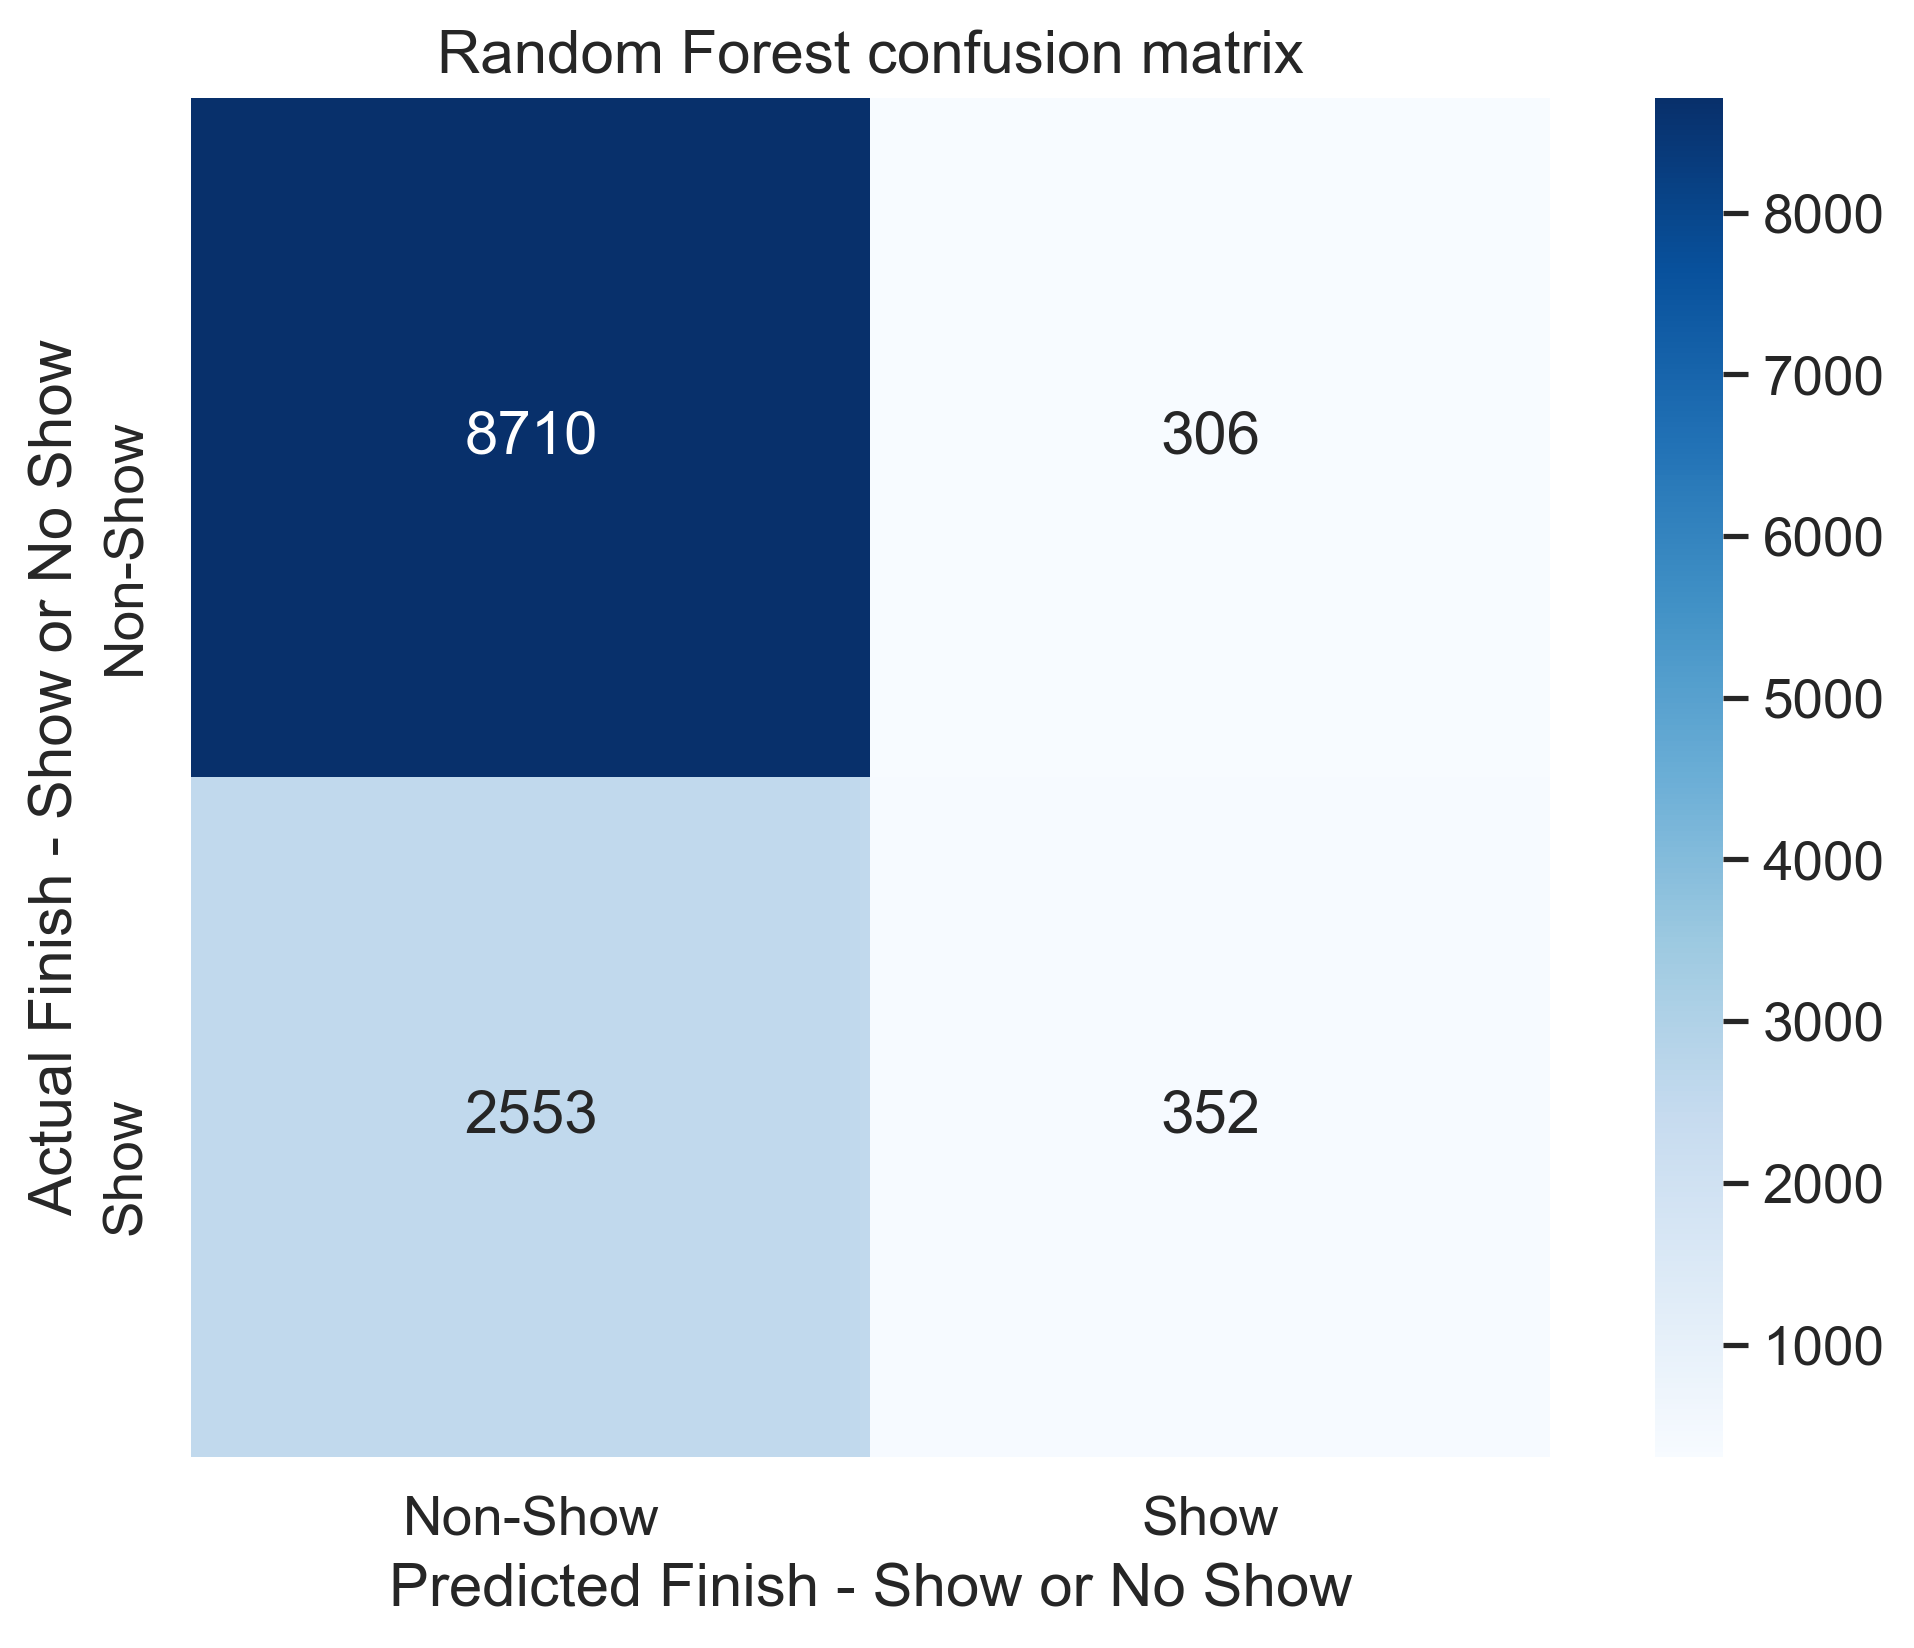

In [114]:
confusion_matrix_generator(cm, 'Random Forest')

Feature Importance:

In [115]:
importance = rf_model.feature_importances_

In [116]:
from matplotlib import pyplot

In [117]:
for i,v in enumerate(importance, 1):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance

for i,feature in enumerate(columns_1, 1):
    print("Feature {}: {}".format(i, feature))

Feature: 1, Score: 0.00941
Feature: 2, Score: 0.06635
Feature: 3, Score: 0.04530
Feature: 4, Score: 0.02743
Feature: 5, Score: 0.04614
Feature: 6, Score: 0.07054
Feature: 7, Score: 0.08010
Feature: 8, Score: 0.07165
Feature: 9, Score: 0.07171
Feature: 10, Score: 0.02299
Feature: 11, Score: 0.04977
Feature: 12, Score: 0.02157
Feature: 13, Score: 0.03855
Feature: 14, Score: 0.06998
Feature: 15, Score: 0.03786
Feature: 16, Score: 0.06998
Feature: 17, Score: 0.03545
Feature: 18, Score: 0.05272
Feature: 19, Score: 0.03278
Feature: 20, Score: 0.02410
Feature: 21, Score: 0.05562
Feature 1: horse_age
Feature 2: declared_weight
Feature 3: actual_weight
Feature 4: horse_rating
Feature 5: draw
Feature 6: three_race_rolling_avg_finish
Feature 7: three_race_rolling_average_lengths
Feature 8: three_race_rolling_average_time
Feature 9: three_race_rolling_average_distance_per_time
Feature 10: field_rating_rank
Feature 11: diff_from_field_rating_avg
Feature 12: field_age_rank
Feature 13: diff_from_fiel

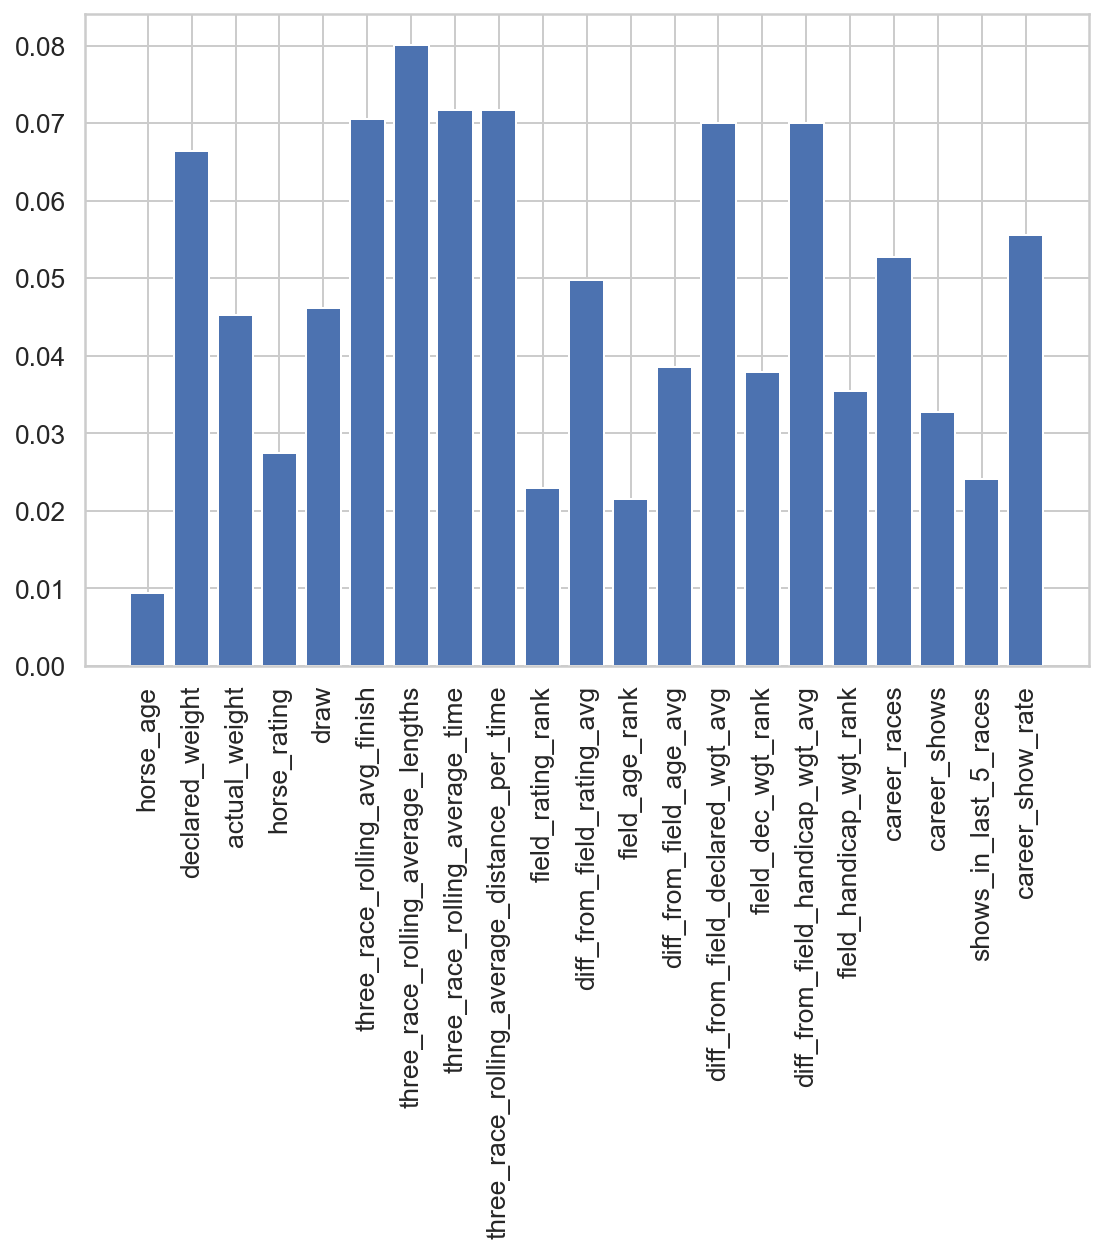

In [118]:
pyplot.bar(columns_1, importance)
pyplot.xticks(ticks = columns_1, labels=columns_1, rotation=90)
pyplot.show()

Looks like the least important features are horse_age, horse_rating, field_rating_rank, field_age_rank, shows_in_last_5_races.  Re-running without these:

In [119]:
columns_2 = ['declared_weight', 'actual_weight', 'draw', 'three_race_rolling_avg_finish', 'three_race_rolling_average_lengths', 'three_race_rolling_average_time', 'three_race_rolling_average_distance_per_time', 'diff_from_field_rating_avg', 'diff_from_field_age_avg', 'diff_from_field_declared_wgt_avg', 'field_dec_wgt_rank', 'diff_from_field_handicap_wgt_avg', 'field_handicap_wgt_rank', 'career_races', 'career_shows', 'career_show_rate']

In [121]:
for i, feature in enumerate(columns_2, 1):
    print("Feature {}: {}".format(i, feature))

Feature 1: declared_weight
Feature 2: actual_weight
Feature 3: draw
Feature 4: three_race_rolling_avg_finish
Feature 5: three_race_rolling_average_lengths
Feature 6: three_race_rolling_average_time
Feature 7: three_race_rolling_average_distance_per_time
Feature 8: diff_from_field_rating_avg
Feature 9: diff_from_field_age_avg
Feature 10: diff_from_field_declared_wgt_avg
Feature 11: field_dec_wgt_rank
Feature 12: diff_from_field_handicap_wgt_avg
Feature 13: field_handicap_wgt_rank
Feature 14: career_races
Feature 15: career_shows
Feature 16: career_show_rate


In [122]:
X = training_horses_2_copy[columns_2]
y = training_horses_2_copy['show']

In [123]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

Fitting Model:

In [124]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

Scoring Model:

In [125]:
y_pred = rf_model.predict(X_val)

In [126]:
rf_model.score(X_train, y_train)

1.0

In [127]:
rf_model.score(X_val, y_val)

0.7576545591812768

In [128]:
precision_score(y_val, y_pred)

0.5124610591900312

In [129]:
fbeta_score(y_val, y_pred, beta=0.5)

0.30056641695596564

In [130]:
f1_score(y_val, y_pred)

0.18550888074429095

Confusion Matrix:

In [131]:
cm = confusion_matrix(y_val, y_pred)

In [132]:
from logistic_reg_model_eval import confusion_matrix_generator

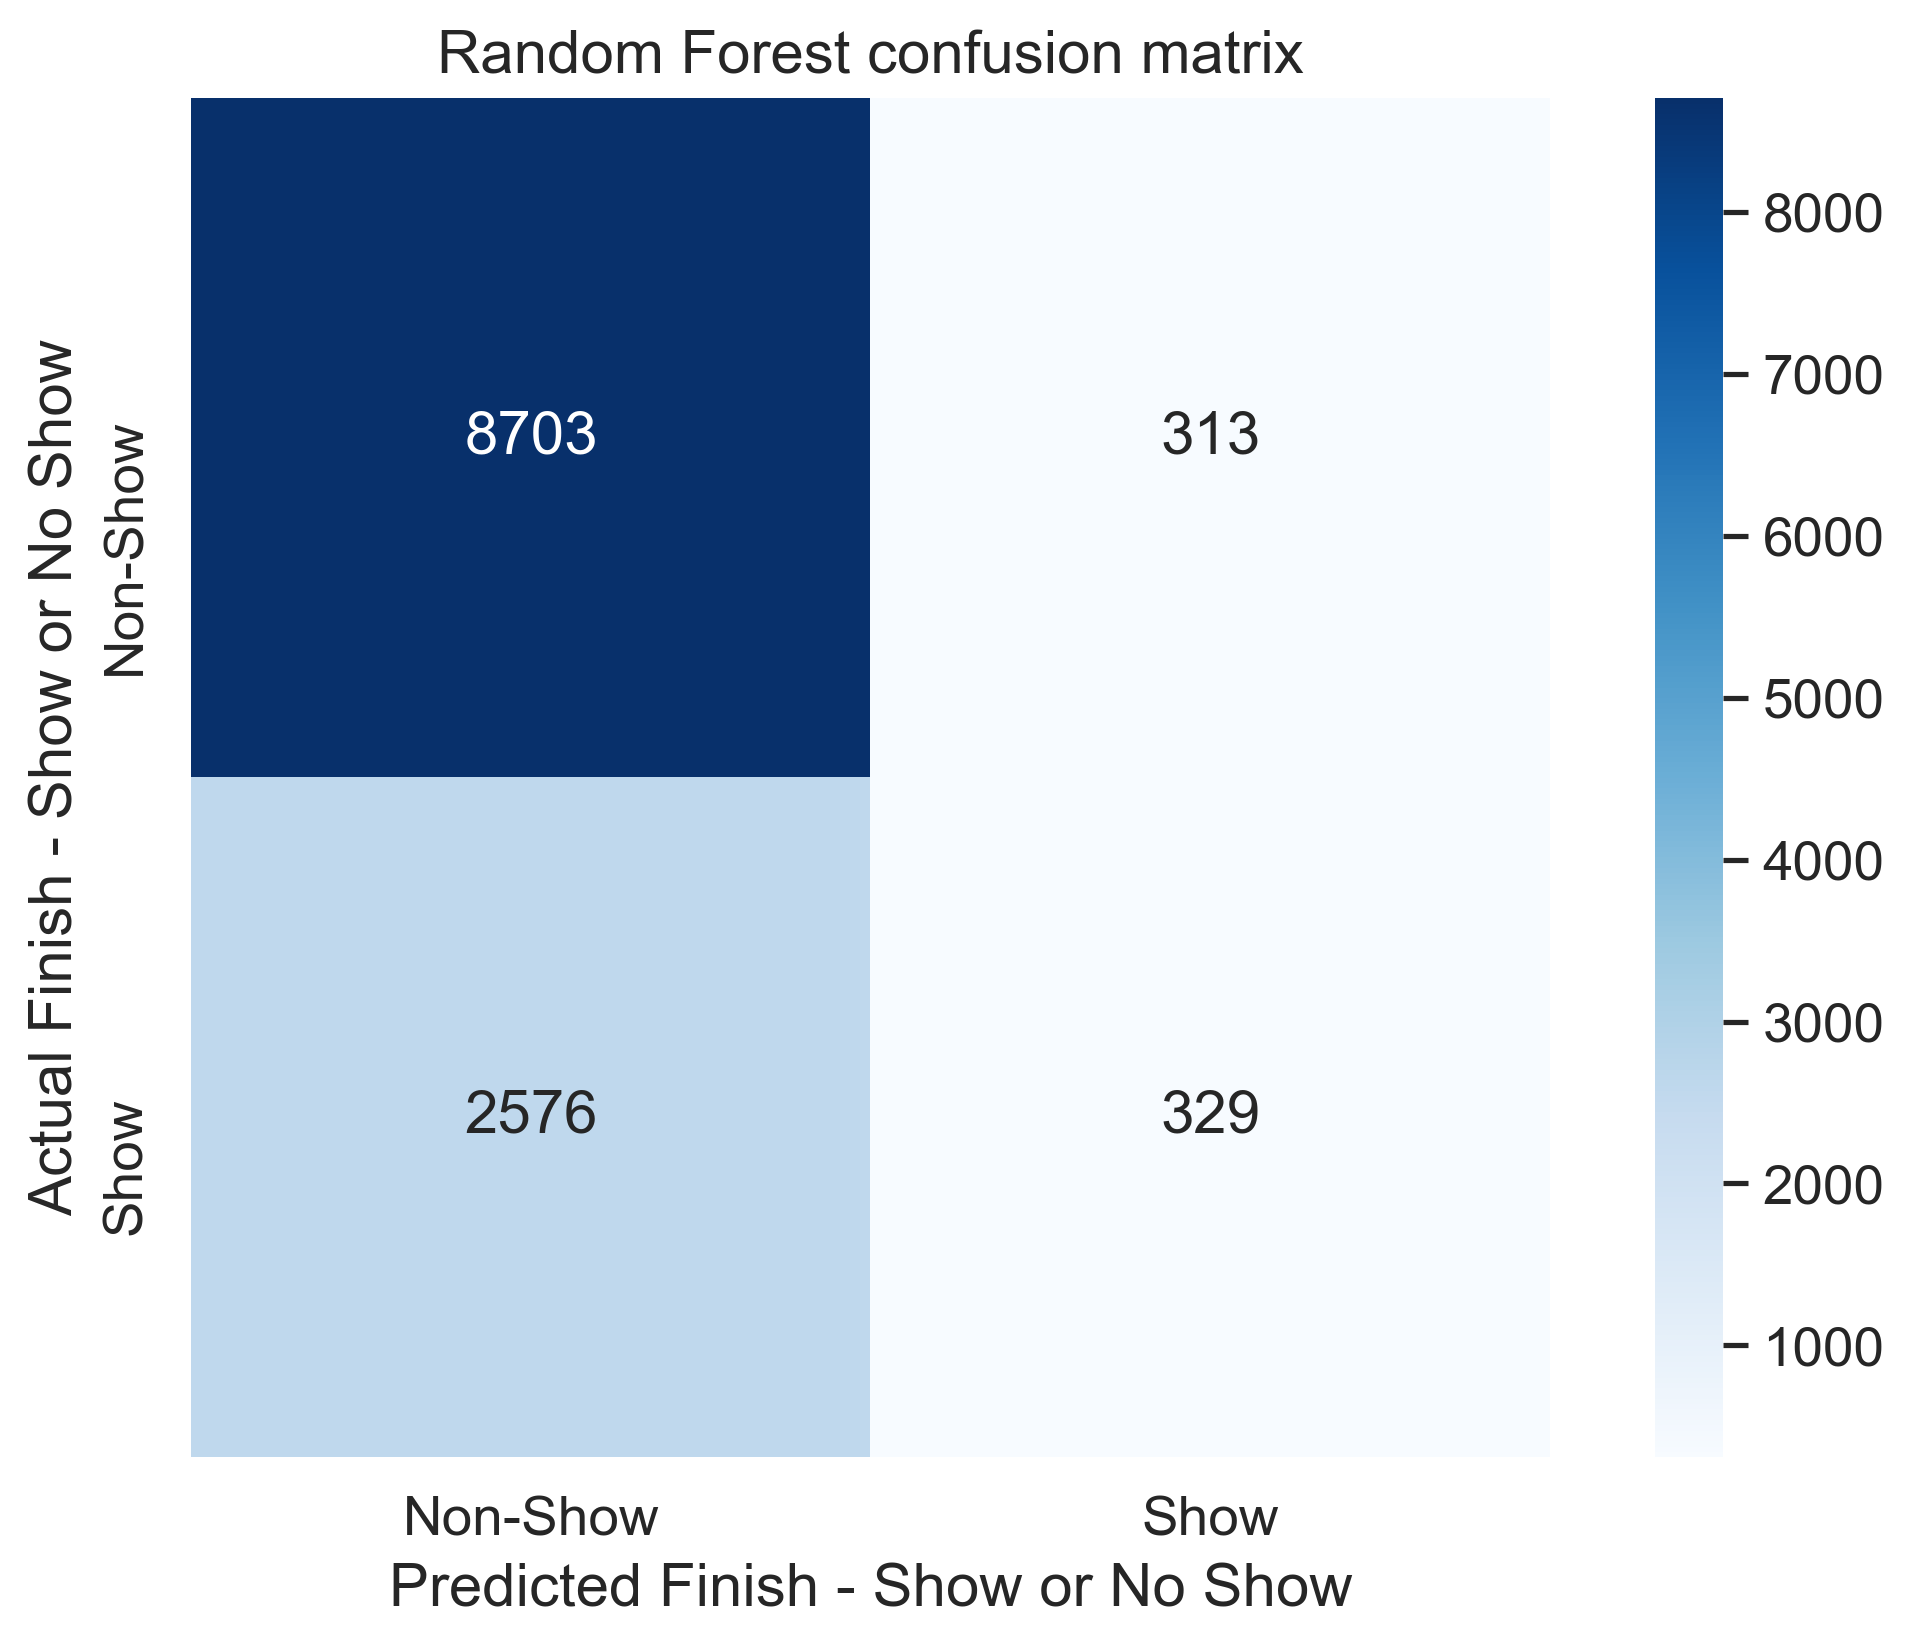

In [133]:
confusion_matrix_generator(cm, 'Random Forest')

Feature Importance:

In [134]:
importance = rf_model.feature_importances_

In [135]:
from matplotlib import pyplot

In [136]:
for i,v in enumerate(importance, 1):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance

for i,feature in enumerate(columns_2, 1):
    print("Feature {}: {}".format(i, feature))

Feature: 1, Score: 0.07385
Feature: 2, Score: 0.04890
Feature: 3, Score: 0.04859
Feature: 4, Score: 0.07481
Feature: 5, Score: 0.09084
Feature: 6, Score: 0.07977
Feature: 7, Score: 0.08068
Feature: 8, Score: 0.06180
Feature: 9, Score: 0.05049
Feature: 10, Score: 0.07781
Feature: 11, Score: 0.04008
Feature: 12, Score: 0.07791
Feature: 13, Score: 0.03770
Feature: 14, Score: 0.05745
Feature: 15, Score: 0.03680
Feature: 16, Score: 0.06253
Feature 1: declared_weight
Feature 2: actual_weight
Feature 3: draw
Feature 4: three_race_rolling_avg_finish
Feature 5: three_race_rolling_average_lengths
Feature 6: three_race_rolling_average_time
Feature 7: three_race_rolling_average_distance_per_time
Feature 8: diff_from_field_rating_avg
Feature 9: diff_from_field_age_avg
Feature 10: diff_from_field_declared_wgt_avg
Feature 11: field_dec_wgt_rank
Feature 12: diff_from_field_handicap_wgt_avg
Feature 13: field_handicap_wgt_rank
Feature 14: career_races
Feature 15: career_shows
Feature 16: career_show_rat

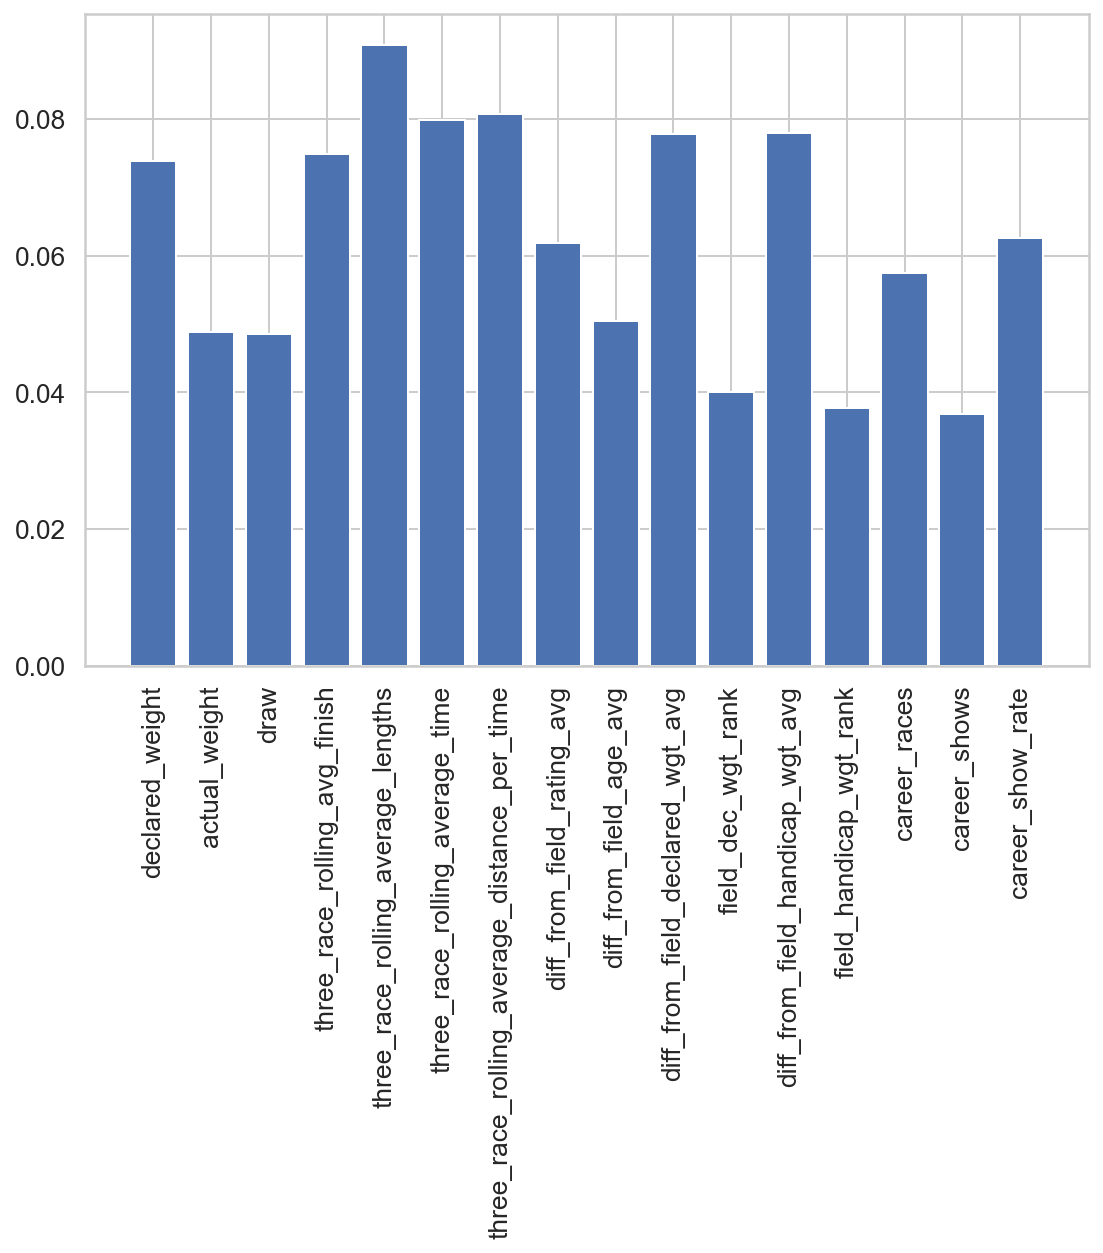

In [137]:
pyplot.bar(columns_2, importance)
pyplot.xticks(ticks = columns_2, labels=columns_2, rotation=90)
pyplot.show()